#### A solution approach for the loan deliquency challenge. 

The first observation without any EDA from the given data was that one class is definitely predominant similar to like detecting outliers in any scenario for a machine learning model. Hence, it is problem of __binary classification with highly imbalanced target data__.

* In this solution file, first step that was followed is to do some EDA analysis on different features and create a summary report for our analysis. Also, check scope converting category variables, find missing value features etc.  

* Secondly, determine if relations between different features and if high correlation is present then do some feature engineering. After that observing the increase in accuracy of the results or so.
    * Approach tried: combining deliquency columns `mi's` for result improvement. But, the results stayed the same or no significant improvement.

* Third, we tried to mitigate the skewness in our variables ( _observed from EDA_ ) with different standardization methodologies like log, log(1+x), tan and percentile linearization methods. Where results from percentile linearlization outperforms other transformations.  

* Finally, build model pipelines of different types to check if which one performed the best on leader-board. The models that we tried were xgboost, lightgbm, extra-trees, ensemble of first three, stacked first three models & fed to another xgboost model and finally settling for logistic regression model. Below we highlight approximate score for some of the models were trained before settling for logistic regression.
    * __lightgbm__, f1-score: 0.028
    * __vote-ensemble(lightgbm, xgboost, extra-trees)__, f1-score: 0.29
    * __stacked-ensemble(lightgbm, random-forest, extra-trees, svm -> xgboost )__, f1-score: 0.23
    * Finally, __logistic regression__, f1-score: 0.315

In [1]:
# import statements for the script.
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import pandas_profiling
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2
import collections
import warnings
warnings.filterwarnings('ignore')


from collections import Counter

In [2]:
# loading train and test datasets.
x1=pd.read_csv(r'train.csv')
x2=pd.read_csv(r'test.csv')

### IQR observartion analysis for feature values

In [3]:
# To observe any outliers being present in the dataframe with thresholds from (min-IQR) to (min+IQR).
# Where, IQR = (75% - 25%) values.
x1.describe()

loan_id  interest_rate  unpaid_principal_bal      loan_term  \
count  1.160580e+05  116058.000000          1.160580e+05  116058.000000   
mean   5.494155e+11       3.868961          2.082262e+05     292.280997   
std    2.597560e+11       0.461020          1.146851e+05      89.762415   
min    1.000009e+11       2.250000          1.100000e+04      60.000000   
25%    3.244656e+11       3.500000          1.200000e+05     180.000000   
50%    5.486239e+11       3.875000          1.830000e+05     360.000000   
75%    7.743034e+11       4.125000          2.780000e+05     360.000000   
max    9.999971e+11       6.750000          1.200000e+06     360.000000   

       loan_to_value  number_of_borrowers  debt_to_income_ratio  \
count  116058.000000        116058.000000         116058.000000   
mean       67.431939             1.593186             30.742293   
std        17.291719             0.491242              9.730798   
min         6.000000             1.000000              1.000000   
25%        57.000000             1.000000             23.000000   
50%        72.000000             2.000000             31.000000   
75%        80.000000             2.000000             39.000000   
max        97.000000             2.000000             64.000000   

       borrower_credit_score  insurance_percent  co-borrower_credit_score  \
count          116058.000000      116058.000000             116058.000000   
mean              769.926778           2.786288                459.611565   
std                42.210706           8.096464                381.946926   
min                 0.000000           0.000000                  0.000000   
25%               751.000000           0.000000                  0.000000   
50%               782.000000           0.000000                740.000000   
75%               800.000000           0.000000                791.000000   
max               840.000000          40.000000                836.000000   

       ...             m4             m5             m6             m7  \
count  ...  116058.000000  116058.000000  116058.000000  116058.000000   
mean   ...       0.002180       0.003533       0.003421       0.004162   
std    ...       0.062161       0.082638       0.087553       0.100961   
min    ...       0.000000       0.000000       0.000000       0.000000   
25%    ...       0.000000       0.000000       0.000000       0.000000   
50%    ...       0.000000       0.000000       0.000000       0.000000   
75%    ...       0.000000       0.000000       0.000000       0.000000   
max    ...       6.000000       7.000000       8.000000       9.000000   

                  m8             m9            m10            m11  \
count  116058.000000  116058.000000  116058.000000  116058.000000   
mean        0.004825       0.005359       0.006617       0.007109   
std         0.113128       0.128242       0.148430       0.162884   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max        10.000000      11.000000      12.000000      13.000000   

                 m12            m13  
count  116058.000000  116058.000000  
mean        0.008065       0.005480  
std         0.178128       0.073824  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max        14.000000       1.000000  

[8 rows x 24 columns]

In [4]:
# For similar analysis we observe test dataframe again.
x2.describe()
# Even, by observation from close relation between 75% and max values. We can conclude that there are no outliers
# present in both train & test dataframe.

loan_id  interest_rate  unpaid_principal_bal     loan_term  \
count  35866.000000   35866.000000          35866.000000  35866.000000   
mean   17933.500000       3.872850         207764.846930    293.130123   
std    10353.766714       0.460537         114561.745828     89.298799   
min        1.000000       2.375000          15000.000000     60.000000   
25%     8967.250000       3.500000         119000.000000    180.000000   
50%    17933.500000       3.875000         182000.000000    360.000000   
75%    26899.750000       4.125000         278000.000000    360.000000   
max    35866.000000       6.625000         802000.000000    360.000000   

       loan_to_value  number_of_borrowers  debt_to_income_ratio  \
count   35866.000000         35866.000000          35866.000000   
mean       67.388334             1.596805             30.762867   
std        17.246741             0.490546              9.726146   
min         5.000000             1.000000              1.000000   
25%        57.000000             1.000000             23.000000   
50%        72.000000             2.000000             31.000000   
75%        80.000000             2.000000             39.000000   
max        97.000000             2.000000             55.000000   

       borrower_credit_score  insurance_percent  co-borrower_credit_score  \
count           35866.000000       35866.000000              35866.000000   
mean              769.926504           2.729409                462.436681   
std                41.779664           8.029155                381.314899   
min                 0.000000           0.000000                  0.000000   
25%               751.000000           0.000000                  0.000000   
50%               782.000000           0.000000                742.000000   
75%               799.000000           0.000000                791.000000   
max               839.000000          35.000000                832.000000   

       ...            m3            m4            m5            m6  \
count  ...  35866.000000  35866.000000  35866.000000  35866.000000   
mean   ...      0.001952      0.002007      0.002705      0.002370   
std    ...      0.056838      0.059238      0.071770      0.066958   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      5.000000      5.000000      6.000000      6.000000   

                 m7            m8            m9           m10           m11  \
count  35866.000000  35866.000000  35866.000000  35866.000000  35866.000000   
mean       0.003374      0.003680      0.004322      0.005548      0.006162   
std        0.086539      0.092898      0.099676      0.121322      0.141455   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        7.000000      5.000000      6.000000      7.000000      8.000000   

                m12  
count  35866.000000  
mean       0.007333  
std        0.160602  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        9.000000  

[8 rows x 23 columns]

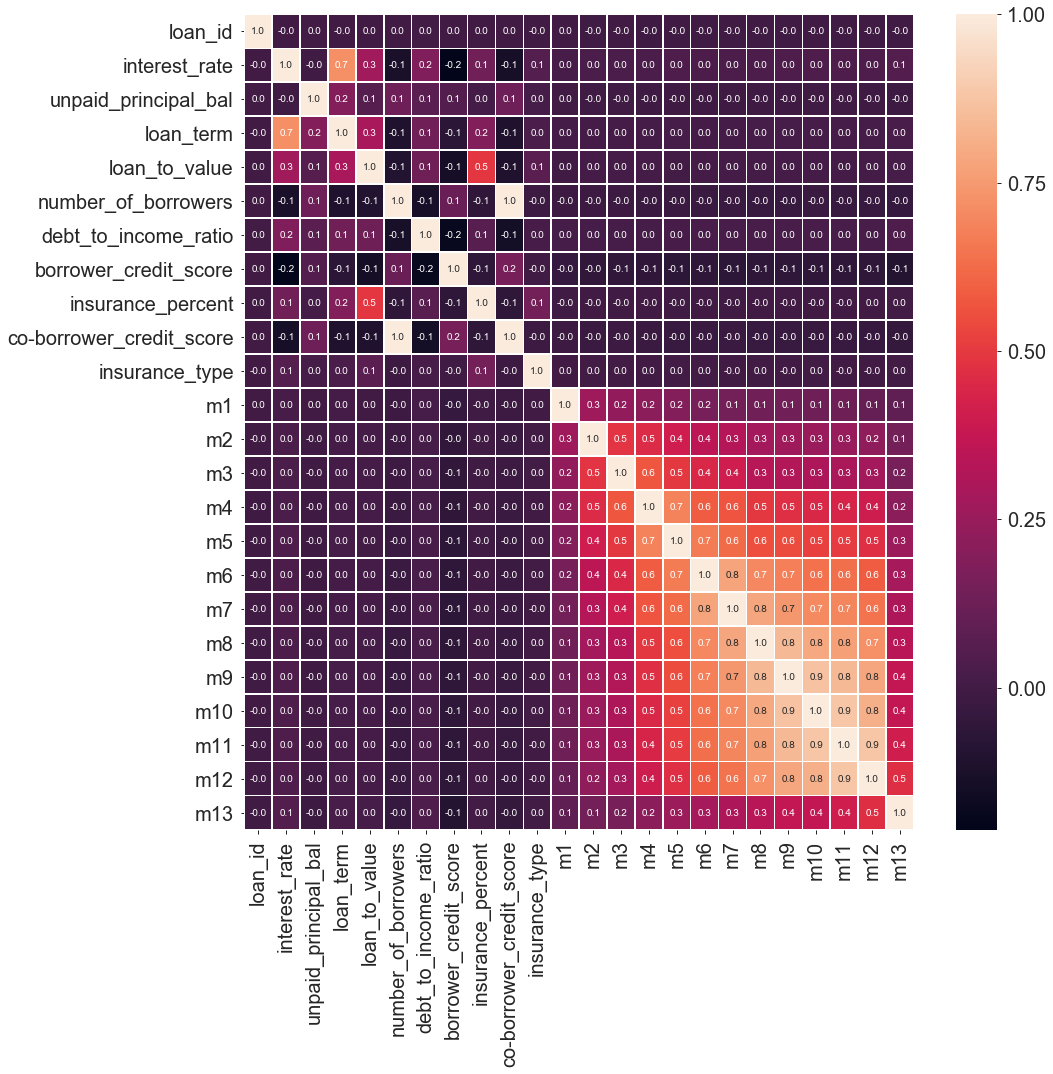

In [5]:
# plot training dataset heatmap
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(x1.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Combining train and test dataframes for carrying out EDA of the given dataframes.

In [6]:
# Combine train & test dataset
y_train = x1['m13']
train_ = x1.drop('m13',axis=1)
test_ = x2
combined_set = pd.concat([train_, test_], axis = 0) # Stacks them vertically

In [7]:
combined_set.head()

loan_id source       financial_institution  interest_rate  \
0  268055008619      Z  Turner, Baldwin and Rhodes          4.250   
1  672831657627      Y  Swanson, Newton and Miller          4.875   
2  742515242108      Z              Thornton-Davis          3.250   
3  601385667462      X                       OTHER          4.750   
4  273870029961      X                       OTHER          4.750   

   unpaid_principal_bal  loan_term origination_date first_payment_date  \
0                214000        360       2012-03-01            05/2012   
1                144000        360       2012-01-01            03/2012   
2                366000        180       2012-01-01            03/2012   
3                135000        360       2012-02-01            04/2012   
4                124000        360       2012-02-01            04/2012   

   loan_to_value  number_of_borrowers  ...  m3  m4 m5  m6  m7  m8  m9  m10  \
0             95                  1.0  ...   0   0  0   0   1   0   0    0   
1             72                  1.0  ...   0   0  0   0   0   0   0    0   
2             49                  1.0  ...   0   0  0   0   0   0   0    0   
3             46                  2.0  ...   0   0  0   0   0   0   1    1   
4             80                  1.0  ...   2   3  4   5   6   7   8    9   

   m11  m12  
0    0    0  
1    1    0  
2    0    0  
3    1    1  
4   10   11  

[5 rows x 28 columns]

In [8]:
combined_set.dtypes

loan_id                       int64
source                       object
financial_institution        object
interest_rate               float64
unpaid_principal_bal          int64
loan_term                     int64
origination_date             object
first_payment_date           object
loan_to_value                 int64
number_of_borrowers         float64
debt_to_income_ratio        float64
borrower_credit_score       float64
loan_purpose                 object
insurance_percent           float64
co-borrower_credit_score    float64
insurance_type              float64
m1                            int64
m2                            int64
m3                            int64
m4                            int64
m5                            int64
m6                            int64
m7                            int64
m8                            int64
m9                            int64
m10                           int64
m11                           int64
m12                         

In [9]:
combined_set.shape

(151924, 28)

In [10]:
# Converting categorical variables to equivalent numerical representation.
# convert financial_instuition to category and convert it to number
combined_set["financial_institution"] = combined_set["financial_institution"].astype('category')
combined_set["financial_institution"] = combined_set["financial_institution"].cat.codes

# Same categorical analysis for first_payment_date 
combined_set["first_payment_date"] = combined_set["first_payment_date"].astype('category')
# print(combined_set.dtypes)
combined_set["first_payment_date"] = combined_set["first_payment_date"].cat.codes

combined_set["insurance_type"] = combined_set["insurance_type"].astype('category')
combined_set["insurance_type"] = combined_set["insurance_type"].cat.codes

combined_set["loan_purpose"] = combined_set["loan_purpose"].astype('category')
combined_set["loan_purpose"] = combined_set["loan_purpose"].cat.codes

combined_set["origination_date"] = combined_set["origination_date"].astype('category')
combined_set["origination_date"] = combined_set["origination_date"].cat.codes

combined_set["source"] = combined_set["source"].astype('category')
combined_set["source"] = combined_set["source"].cat.codes

In [11]:
combined_set.shape

(151924, 28)

__Note:__ Uncomment the code below for executing pandas profiling code.

In [12]:
# Getting complete EDA summary with pandas profiling in the form of a html d

# profile = combined_set.profile_report(title='Pandas Profiling Report')
# profile.to_file(output_file="eda_summary.html")

In [13]:
# pandas_profiling.ProfileReport(combined_set)

#### Inferences made from the above analysis. 

* High correlation of `number_of_borrowers` feature with `co-borrower_credit_score`. Hence, removing that column from the analysis.  
* Majority of the features being highly skewed in nature upto 99.6% of storing only one value.  
* Definitely high correlation observed between all the `mi` values.  
* Relatively large distinct counts for `interest_rate`, `unpaid_principal_bal` features.

#### Mitigating solutions used and applied.

* Dropping off the `number_of_borrower` feature.
* Using different transformations like log, log(1+x), tanh etc. Finally, using percentile linearization standardization giving best results.
* Feature engineering of `mi` values to create new features didn't improved performance on given model. Hence, omitting the feature engineered columns. 
* Binning values for `interest_rate`, `unpaid_principal_bal` features to make the model more lucid in nature.

In [14]:
del combined_set['number_of_borrowers']

In [15]:
size = combined_set.shape[0]-1
combined_set.iloc[:,1:] = combined_set.iloc[:,1:].rank(method='min').apply(lambda x: (x-1)/size)
combined_set.describe()

loan_id         source  financial_institution  interest_rate  \
count  1.519240e+05  151924.000000          151924.000000  151924.000000   
mean   4.197103e+11       0.288309               0.366187       0.458692   
std    3.255504e+11       0.333390               0.287701       0.289240   
min    1.000000e+00       0.000000               0.000000       0.000000   
25%    1.158882e+11       0.000000               0.004180       0.218525   
50%    4.103649e+11       0.000000               0.424774       0.362144   
75%    7.040456e+11       0.550094               0.424774       0.705627   
max    9.999971e+11       0.873989               0.984288       1.000000   

       unpaid_principal_bal      loan_term  origination_date  \
count         151924.000000  151924.000000     151924.000000   
mean               0.498074       0.274325          0.372655   
std                0.288695       0.150472          0.260419   
min                0.000000       0.000000          0.000000   
25%                0.248981       0.065408          0.236080   
50%                0.497463       0.380436          0.236080   
75%                0.748728       0.380436          0.559224   
max                1.000000       0.380436          0.903701   

       first_payment_date  loan_to_value  debt_to_income_ratio  ...  \
count       151924.000000  151924.000000         151924.000000  ...   
mean             0.374349       0.473324              0.485733  ...   
std              0.323315       0.269570              0.287013  ...   
min              0.000000       0.000000              0.000000  ...   
25%              0.003449       0.246750              0.228287  ...   
50%              0.317292       0.484028              0.480447  ...   
75%              0.665100       0.689975              0.736630  ...   
max              0.970320       0.994642              1.000000  ...   

                  m3             m4             m5             m6  \
count  151924.000000  151924.000000  151924.000000  151924.000000   
mean        0.001630       0.001683       0.002509       0.002214   
std         0.040311       0.040955       0.049975       0.046961   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         0.999987       0.999993       0.999993       1.000000   

                  m7             m8             m9            m10  \
count  151924.000000  151924.000000  151924.000000  151924.000000   
mean        0.002719       0.002929       0.003132       0.003760   
std         0.052014       0.053977       0.055807       0.061117   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                 m11            m12  
count  151924.000000  151924.000000  
mean        0.003748       0.004219  
std         0.061015       0.064707  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000  

[8 rows x 27 columns]

#### Binning the `interest_rate` in 200 buckets and making the model even more simpler.

In [16]:
# let's prepare a binning value list for interest_rate columns.
# 199 bins created with unique 200 values.
inc_val = 1/200
i = 0
bins = []
for i in range(201):
    val = i*inc_val
    bins.append(val)
    i = i+1

In [17]:
combined_set.columns.get_loc("interest_rate")

3

In [18]:
# replacing values with binned out labels.
combined_set['interest_rate'] = np.searchsorted(bins, combined_set['interest_rate'].values)
# After that percentage linearized values replacement.
combined_set.iloc[:,3] = combined_set.iloc[:,3].rank(method='min').apply(lambda x: (x-1)/size)

#### Binning the `unpaid_principal_bal` in 200 buckets and making the model even more simpler.

In [19]:
combined_set.columns.get_loc("unpaid_principal_bal")

4

In [20]:
# unpaid_principle, binning needed to be done upto 199 bins approximately.
combined_set['unpaid_principal_bal'] = np.searchsorted(bins, combined_set['unpaid_principal_bal'].values)
# After that percentage linearized values replacement.
combined_set.iloc[:,4] = combined_set.iloc[:,4].rank(method='min').apply(lambda x: (x-1)/size)

#### Binning, categorization and linearization portion completed. Again, generating EDA report for any further analysis of the dataframe.

__Note:__ Uncomment the code below for executing pandas profiling code.

In [21]:
# pandas_profiling.ProfileReport(combined_set)

In [22]:
combined_set.head()

loan_id    source  financial_institution  interest_rate  \
0  268055008619  0.873989               0.984288       0.775037   
1  672831657627  0.550094               0.908645       0.975889   
2  742515242108  0.873989               0.978581       0.071029   
3  601385667462  0.000000               0.424774       0.963264   
4  273870029961  0.000000               0.424774       0.963264   

   unpaid_principal_bal  loan_term  origination_date  first_payment_date  \
0              0.595499   0.380436          0.903701            0.665100   
1              0.351263   0.380436          0.236080            0.003449   
2              0.880328   0.065408          0.236080            0.003449   
3              0.310796   0.380436          0.559224            0.317292   
4              0.266734   0.380436          0.559224            0.317292   

   loan_to_value  debt_to_income_ratio  ...        m3        m4        m5  \
0       0.956748              0.199160  ...  0.000000  0.000000  0.000000   
1       0.484028              0.902911  ...  0.000000  0.000000  0.000000   
2       0.157955              0.544921  ...  0.000000  0.000000  0.000000   
3       0.131560              0.902911  ...  0.000000  0.000000  0.000000   
4       0.689975              0.868572  ...  0.999822  0.999888  0.999908   

         m6        m7        m8        m9       m10       m11       m12  
0  0.000000  0.997282  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.996248  0.000000  
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3  0.000000  0.000000  0.000000  0.996867  0.996235  0.996248  0.995774  
4  0.999947  0.999947  0.999967  0.999967  0.999967  0.999974  0.999980  

[5 rows x 27 columns]

In [23]:
# Now, splitting the dataframe & applying standard scaler to the given data for transformation.
df_train = combined_set.iloc[:train_.shape[0],1:] # Up to the last initial training set row.
df_test = combined_set.iloc[train_.shape[0]:,1:] # Past the last initial training set row.

In [24]:
df_train.head()

source  financial_institution  interest_rate  unpaid_principal_bal  \
0  0.873989               0.984288       0.775037              0.595499   
1  0.550094               0.908645       0.975889              0.351263   
2  0.873989               0.978581       0.071029              0.880328   
3  0.000000               0.424774       0.963264              0.310796   
4  0.000000               0.424774       0.963264              0.266734   

   loan_term  origination_date  first_payment_date  loan_to_value  \
0   0.380436          0.903701            0.665100       0.956748   
1   0.380436          0.236080            0.003449       0.484028   
2   0.065408          0.236080            0.003449       0.157955   
3   0.380436          0.559224            0.317292       0.131560   
4   0.380436          0.559224            0.317292       0.689975   

   debt_to_income_ratio  borrower_credit_score  ...        m3        m4  \
0              0.199160               0.057674  ...  0.000000  0.000000   
1              0.902911               0.063322  ...  0.000000  0.000000   
2              0.544921               0.476031  ...  0.000000  0.000000   
3              0.902911               0.003364  ...  0.000000  0.000000   
4              0.868572               0.035867  ...  0.999822  0.999888   

         m5        m6        m7        m8        m9       m10       m11  \
0  0.000000  0.000000  0.997282  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.996248   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.996867  0.996235  0.996248   
4  0.999908  0.999947  0.999947  0.999967  0.999967  0.999967  0.999974   

        m12  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.995774  
4  0.999980  

[5 rows x 26 columns]

In [25]:
df_test.head()

source  financial_institution  interest_rate  unpaid_principal_bal  \
0  0.550094               0.004180       0.360972              0.945894   
1  0.000000               0.424774       0.905011              0.223047   
2  0.550094               0.424774       0.905011              0.065810   
3  0.000000               0.380133       0.705002              0.263443   
4  0.000000               0.004180       0.071029              0.439506   

   loan_term  origination_date  first_payment_date  loan_to_value  \
0   0.380436           0.09907            0.763926       0.544045   
1   0.380436           0.09907            0.763926       0.689975   
2   0.380436           0.00000            0.873818       0.544045   
3   0.065408           0.09907            0.763926       0.092889   
4   0.065408           0.09907            0.763926       0.199101   

   debt_to_income_ratio  borrower_credit_score  ...   m3   m4   m5   m6   m7  \
0              0.146258               0.600719  ...  0.0  0.0  0.0  0.0  0.0   
1              0.544921               0.646907  ...  0.0  0.0  0.0  0.0  0.0   
2              0.577365               0.095680  ...  0.0  0.0  0.0  0.0  0.0   
3              0.257091               0.719983  ...  0.0  0.0  0.0  0.0  0.0   
4              0.019951               0.353363  ...  0.0  0.0  0.0  0.0  0.0   

    m8   m9  m10  m11  m12  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  

[5 rows x 26 columns]

### Model Building 

Since, f1-score is the final evaluation criteria models like logisitic regression performs significantly well for this classification problem even better than the multiple ensemble models created with decision tree based algorithms. Hence, a lucid and light logistic regression is trained with cross-validation on the most optimized parameters for achieving the final results.

* Since, data is highly skewed for this binary class prediction problem we have used `class_weight` to regularize on the distribution issue which led to significant result improvement.
* Normalization part of data is not done as it didn't lead to any performance improvement after percentile linearlization.
* We carry out grid search to optimize our model of logistic regression. Also, we carry out OOF cross-validation for this model both while searching parameters and training the final model on optimized parameters.
* Finally, the area under ROC curve was also considered for selecting the best model. As, f1-score was the criteria area under ROC curve is also an equivalently good loss function for optimization.
* In the end we carried out 5 fold CV for our logistic regression model and converted the predictions into classifier results accordingly.

In [26]:
# Let's skip standard scaling, only restrict to percent linearization only.
train = df_train
test = df_test
labels = y_train
# dataframes prepared: train, test, labels. 
# Now, let's build a standalone logistic regression model.

In [27]:
# Grid Search for logistic regression.
from sklearn.linear_model import LogisticRegression
# f1_score is being used as a final metric for evaluation.
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve, auc, f1_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
seed =45
plt.style.use('fivethirtyeight')

In [28]:
logreg = LogisticRegression(class_weight='balanced')
param = {'C':[0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3]}
clf = GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=10)
clf.fit(train,labels)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.8955, with best C: {'C': 0.01}


In [29]:
X = train
y = labels
x_test = test

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
pred_test_full =0
cv_score =[]
i=1

for train_index, test_index in kf.split(X,y):
    
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    lr = LogisticRegression(C=1.618034)
    lr.fit(xtr,ytr)
    score = roc_auc_score(yvl,lr.predict(xvl))
    print('ROC AUC score:',score)
    cv_score.append(score)    
    pred_test = lr.predict_proba(x_test)[:,1]
    pred_test_full +=pred_test
    i+=1

1 of KFold 5
ROC AUC score: 0.6871317955382282
2 of KFold 5
ROC AUC score: 0.6809940667747916
3 of KFold 5
ROC AUC score: 0.6730117462141005
4 of KFold 5
ROC AUC score: 0.6848227698361479
5 of KFold 5
ROC AUC score: 0.6964605132641213


#### Visualizing & printing out cofusion matrix for an analysis of f1-score, precision and recall analysis.

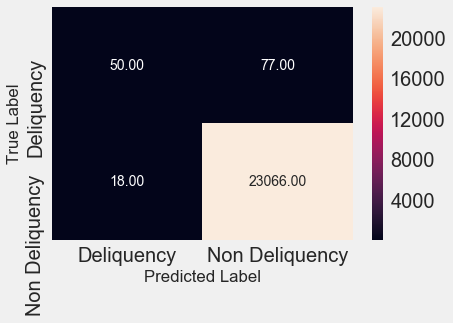

In [30]:
from sklearn import metrics
def draw_cm(actual, predicted):
    cm = metrics.confusion_matrix(actual, predicted,[1,0])
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Deliquency', 'Non Deliquency'],
               yticklabels = ['Deliquency', 'Non Deliquency'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
draw_cm(yvl, lr.predict(xvl))

In [31]:
print('Confusion matrix\n',confusion_matrix(yvl,lr.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Confusion matrix
 [[23066    18]
 [   77    50]]
Cv [0.6871317955382282, 0.6809940667747916, 0.6730117462141005, 0.6848227698361479, 0.6964605132641213] 
Mean cv Score 0.6844841783254779


In [32]:
lr.coef_

array([[ 0.25176224, -0.05522652,  0.52755637, -0.39041469,  0.16338842,
        -0.18405212, -0.00517312, -0.15449351,  0.71899629, -2.37302973,
        -0.01686061,  0.1032705 , -0.92834206,  0.61186426,  1.49442596,
         0.53450355, -0.62382525,  0.94201314,  0.71165989, -0.03947559,
         0.5374326 ,  0.99346825,  1.36047783,  0.70895517,  2.06416871,
         4.09973903]])

In [33]:
lr.score(xvl,yvl)

0.995907113006764

#### Operating characteristics of the model for observing ROC curve performance of the model.

Text(0.5, 0, 'False positive rate')

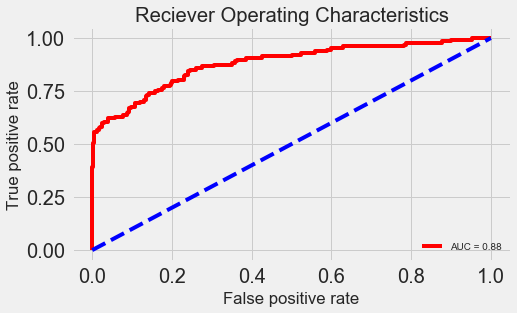

In [34]:

proba = lr.predict_proba(xvl)[:,1]
frp,trp, threshold = roc_curve(yvl,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(7,4))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [35]:
y_pred = pred_test_full/5
y_pred

array([0.0017333 , 0.00217072, 0.01616753, ..., 0.03378968, 0.00676372,
       0.0082752 ])

In [36]:
submit = pd.DataFrame({'loan_id':test_['loan_id'],'m13':pred_test_full})

In [37]:
submit.head()

loan_id       m13
0        1  0.008667
1        2  0.010854
2        3  0.080838
3        4  0.004651
4        5  0.006987

In [38]:
submit.to_csv('logistic_reg_result_reg_grid_search.csv', index=False)

In [39]:
submit['m13'] = submit['m13'].apply(lambda x: 1 if x>=0.5 else 0)

In [40]:
submit.head()

loan_id  m13
0        1    0
1        2    0
2        3    0
3        4    0
4        5    0

In [41]:
submit.to_csv('logistic_reg_result_class_grid_search.csv', index=False)